In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import random

# module imports
! pip install polyleven
#from data.pairs import make_entries
import distances
from geocoding import geocode




[notice] A new release of pip is available: 23.1.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
def make_entries():
    """
    Creates a pandas dataframe with the following columns: address1, address2, label, 
    where each entry represents a pair of addresses and their label (0 for different, 1 for same)
    """
    # initialize pandas dataframe with defined columns
    df = pd.DataFrame(columns=['address1', 'address2', 'label'])

    # open addresses json file
    with open("data/addresses_data.json") as f:
        addresses = json.load(f)
    addresses = addresses["res"]

    # add case1 entries
    df = pd.concat([df, case1(addresses)], ignore_index=True)

    # add case4 entries
    df = pd.concat([df, case4(addresses)], ignore_index=True)

    return df


def case1(addresses):
    """
    Given a list of addresses, return a DF with the following entries as epcified by case1:
    For every address object, create an entry with the unstructured address to itself with a label of 1
    """
    df = pd.DataFrame(columns=['address1', 'address2', 'label'])
    for address in addresses:
        string_add = address["street_address"] + ", " + \
            address["city"] + ", " + address["state"] + " " + address["zip"]
        df.loc[len(df)] = {'address1': string_add, 'address2': string_add,
                           'label': 1}
    return df


def case4(addresses):
    """
    Given a list of addresses, return a DF with the 10000 entries as epcified by case4:
    Select two random addresses with label 0
    """
    df = pd.DataFrame(columns=['address1', 'address2', 'label'])
    for i in range(10000):
        # select two random addresses
        address1 = random.choice(addresses)
        address2 = random.choice(addresses)
        # make sure they are different
        while address1 == address2:
            address2 = random.choice(addresses)
        # create entry
        string_add1 = address1["street_address"] + ", " + \
            address1["city"] + ", " + address1["state"] + " " + address1["zip"]
        string_add2 = address2["street_address"] + ", " + \
            address2["city"] + ", " + address2["state"] + " " + address2["zip"]
        df.loc[len(df)] = {'address1': string_add1,
                           'address2': string_add2, 'label': 0}
    return df


In [3]:
addresses = make_entries()

In [5]:
addresses[11000:11010]

,address1,address2,label
11000,"1751 VETERANS DR STE 125, FLORENCE, AL 35630","LANDSTUHL REGIONAL MEDICAL CENTER, APO, AE 09180",0
11001,"4383 MEDICAL DR STE 126, SAN ANTONIO, TX 78229","3449 WILKENS AVE STE 101, BALTIMORE, MD 21229",0
11002,"1550 E WASHINGTON ST STE 101, COLTON, CA 92324","1641 E POLSTON AVE, POST FALLS, ID 83854",0
11003,"204 PROCTOR AVE, REVERE, MA 02151","1760 NICHOLASVILLE RD, LEXINGTON, KY 40503",0
11004,"48 CROSS PARK CT, GREENVILLE, SC 29605","3299 WOODBURN RD, ANNANDALE, VA 22003",0
11005,"450 STABLERIDGE ST, EL CAJON, CA 92019","LANDSTUHL REGIONAL MEDICAL CENTER, UNIT 33100,...",0
11006,"725 RESERVOIR AVE, CRANSTON, RI 02910","200 HIGH SERVICE AVE, NORTH PROVIDENCE, RI 02904",0
11007,"18100 OAKWOOD BLVD STE 213, DEARBORN, MI 48124","420 FRANKLIN ST, RUMFORD, ME 04276",0
11008,"1000 HIGHWAY 12 WEST RIVER HEALTH SERVICES-, H...","BDAACH/549TH HC, APO, AP 96271",0
11009,"3321 COLORADO BLVD, DENTON, TX 76210","3600 FLORIDA BLVD, BATON ROUGE, LA 70806",0


### Vectorization of Addresses

In [6]:
import label
from distances import distance_jaro_winkler
import usaddress

# Create a new dataframe to store the labeled entries and distance features
dist_jaro = pd.DataFrame(columns=['address_number_dist', 'street_name_dist', 'secondary_address_dist', 'city_dist', 'state_dist', 'postal_code', 'label'])
labels = ['address_number', 'street_name', 'secondary_address', 'city', 'state', 'postal_code']
# Iterate over each entry in the addresses dataframe
count_throw_out = 0
for index, row in addresses.iterrows():
  try:
    address1 = row['address1']
    address2 = row['address2']
    labeled_1 = usaddress.tag(address1, tag_mapping=label.address_map_dict)[0]
    labeled_2 = usaddress.tag(address2, tag_mapping=label.address_map_dict)[0]
    
    #handle cases with different number of labels
    for l in labels:
      if l not in labeled_1:
        labeled_1.update({l:''})
      if l not in labeled_2:
        labeled_2.update({l:''})
  
  # Add the labeled entry and distance feature to the new dataframe
    dist_jaro.loc[index-(count_throw_out)] = {
      'address_number_dist':distance_jaro_winkler(labeled_1['address_number'], labeled_2['address_number']), 
      'street_name_dist':distance_jaro_winkler(labeled_1['street_name'], labeled_2['street_name']),
      'secondary_address_dist':distance_jaro_winkler(labeled_1['secondary_address'], labeled_2['secondary_address']),
      'city_dist':distance_jaro_winkler(labeled_1['city'], labeled_2['city']),
      'state_dist':distance_jaro_winkler(labeled_1['state'], labeled_2['state']),
      'postal_code':distance_jaro_winkler(labeled_1['postal_code'], labeled_2['postal_code']),
      'label': row['label']}
  except usaddress.RepeatedLabelError as e :
    count_throw_out += 1
    continue

dist_jaro.describe()



Original Address:62 Main Street Suite 4b, New Paltz, NY 12561

[
    {
        "address_number": "62",
        "street_name": "Main Street",
        "secondary_address": "Suite 4b",
        "city": "New Paltz",
        "state": "NY",
        "postal_code": "12561"
    },
    "Street Address"
]


,address_number_dist,street_name_dist,secondary_address_dist,city_dist,state_dist,postal_code,label
count,11065.000000,11065.000000,11065.000000,11065.000000,11065.000000,11065.000000,11065.000000
mean,0.402720,0.585313,0.686799,0.541892,0.189677,0.497655,0.101039
std,0.355054,0.221632,0.457016,0.218658,0.359467,0.276229,0.301394
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.511111,0.000000,0.455347,0.000000,0.466667,0.000000
50%,0.500000,0.587173,1.000000,0.525000,0.000000,0.466667,0.000000
75%,0.666667,0.666411,1.000000,0.607074,0.000000,0.600000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
dist_jaro.tail()

,address_number_dist,street_name_dist,secondary_address_dist,city_dist,state_dist,postal_code,label
11060,0.527778,0.578135,1.00000,0.540741,0.000000,0.600000,0
11061,0.633333,0.683612,0.00000,0.694792,0.000000,0.600000,0
11062,0.000000,0.000000,1.00000,0.000000,0.000000,0.600000,0
11063,0.466667,0.497382,0.52381,0.589064,0.000000,0.466667,0
11064,0.541667,0.446623,1.00000,0.484127,0.666667,0.466667,0


### Model Selection/Experiemntation

#### Logistic Regression

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# split dataset
X = dist_jaro.drop('label', axis=1)
y = dist_jaro['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# create Logisitc Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# predict
y_pred = model.predict(X_test)

# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.9990970654627539

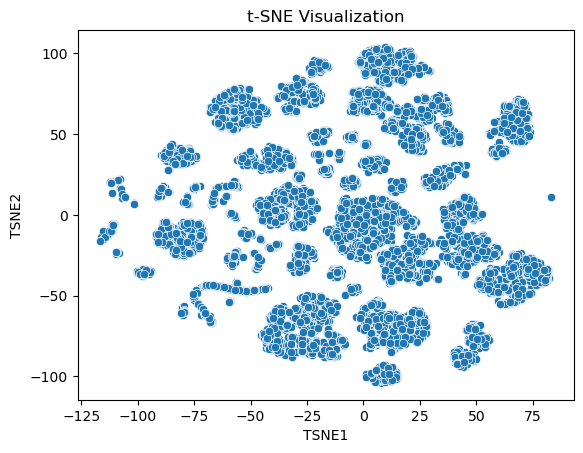

In [62]:
# visiualziation of current data
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = scaler.fit_transform(dist_jaro)

# pca = PCA(n_components=2)  # You can choose the number of components you want
# principal_components = pca.fit_transform(df_scaled)

# pc_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
# pc_df['label'] = dist_jaro['label']

# # Plot the 2D PCA representation
# sns.scatterplot(x='PC1', y='PC2', data=pc_df)
# plt.title('Visualization of dataset with Case 1 and Case 4')
# plt.show()

tsne = TSNE(n_components=2, random_state=42)  # num components
tsne_result = tsne.fit_transform(df_scaled)

# df with tsne results
tsne_df = pd.DataFrame(data=tsne_result, columns=['TSNE1', 'TSNE2'])
tsne_df['label'] = dist_jaro['label']


sns.scatterplot(x='TSNE1', y='TSNE2', data=tsne_df)
plt.title('t-SNE Visualization')
plt.show()
